# Quantitative experiments with Acute Ischemic Stroke
This dataset contains information about medical notes for acute ischemic stroke prediction https://cutt.ly/sQ1nM9c

Use code from here as well:
https://colab.research.google.com/drive/1Chb_17EWiILK5G3MbLtZaIHq1JcbUyJ5?usp=sharing
We used this colab to preprocess the data and to produce embeddings from BioBert to leverage the GPU power of Colab

In [1]:
import sys
sys.path.append('C:\\Users\\iamollas\\Desktop\\Altruist New')
data_path = "C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Preprocessed Data\\D4\\"
model_path = "C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Models\\D4\\"
weights_path = "C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D4\\"

In [2]:
import random
import time
import csv
import warnings
import json
import lime.lime_text as li
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Dense, Flatten, Input, Dropout, concatenate, Conv1D, GlobalMaxPooling1D, SpatialDropout1D, LSTM, Bidirectional
import keras
from keras.models import Model
from innvestigate.utils.keras import checks
import json
import innvestigate
import innvestigate.utils as iutils
from altruist import Altruist
from meta_explain import MetaExplain
from utilities.attention import Attention
from sklearn.preprocessing import maxabs_scale
import numpy as np
np.seterr(invalid='ignore')
warnings.filterwarnings("ignore")


Using TensorFlow backend.


We will now load the preprocessed dataset.

In [3]:
import pickle

with open(data_path+'data.pickle', 'rb') as handle:
    b = pickle.load(handle)

x_train, y_train, x_train_emb = b['train'][0], b['train'][1], b['train'][2]
x_test, y_test, x_test_emb = b['test'][0], b['test'][1], b['test'][2]
del b

In [4]:
x_train_emb = np.array(x_train_emb)
x_test_emb = np.array(x_test_emb)

And we will build two neural network models. One linear and one non-linear, and one uneccessary complex model.

In [5]:
from keras.regularizers import l2

linear_input = Input(shape=(x_train_emb[0].shape))
linear_hidden = Flatten()(linear_input)
linear_output = Dense(1, activation='sigmoid')(linear_hidden)
linear_neural = Model(linear_input, linear_output)
linear_neural.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

neural_input = Input(shape=(x_train_emb[0].shape))
neural_hidden = SpatialDropout1D(0.1)(neural_input)
x = Bidirectional(LSTM(50, dropout=0.5, return_sequences=True))(neural_hidden)
x = GlobalMaxPooling1D()(x)
y = Conv1D(filters=50, kernel_size=3, activation='tanh')(neural_hidden)
y = GlobalMaxPooling1D()(y)
neural_hidden = concatenate([x, y])
neural_hidden = Dropout(0.5)(neural_hidden)
neural_hidden = Dense(250, activation='tanh')(neural_hidden)
neural_output = Dense(1, activation='sigmoid')(neural_hidden)
neural = Model(neural_input, neural_output)
neural.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy'])


complex_input = Input(shape=(x_train_emb[0].shape))
complex_hidden = SpatialDropout1D(0.2)(complex_input)
x = Bidirectional(LSTM(50, dropout=0.5, return_sequences=True))(complex_hidden)
x = concatenate([
    Attention(250)(x),
    GlobalMaxPooling1D()(x),
])
y = Conv1D(filters=50, kernel_size=3, activation='tanh')(complex_hidden)
y = concatenate([
    Attention(248)(y),
    GlobalMaxPooling1D()(y),
])
z = concatenate([
    Attention(250)(complex_hidden),
    GlobalMaxPooling1D()(complex_hidden),
])
complex_hidden = concatenate([x, y, z])
complex_hidden = Dropout(0.7)(complex_hidden)
complex_hidden = Dense(500, activation='tanh')(complex_hidden)
complex_output = Dense(1, activation='sigmoid')(complex_hidden)
complex_neural = Model(complex_input, complex_output)
complex_neural.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

models = {'lNN': linear_neural, 'NN': neural, 'cNN': complex_neural}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Let's evaluate our models!

In [6]:
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score


def compute_scores(name, y_test, y_pred):
    if type(y_pred[0]) == type(np.ndarray([1])):
        y_pred = np.array([1 if i[0] > 0.5 else 0 for i in y_pred])
    print(name)
    print('\t', 'F1:', f1_score(y_test, y_pred, average='macro'))
    print('\t', 'Precision:', precision_score(y_test, y_pred, average='macro'))
    print('\t', 'Recall:', recall_score(y_test, y_pred, average='macro'))
    print('\t', 'Accuracy:', balanced_accuracy_score(y_test, y_pred))

In [7]:
train = False
for name, model in models.items():
    if train:
        check_point = ModelCheckpoint(
            model_path + "D4_"+name+".hdf5", monitor="val_loss", verbose=0, save_best_only=True, mode="auto")
        model.fit(x_train_emb, y_train, epochs=50, batch_size=32, shuffle=True,
                  validation_split=0.1, verbose=1, callbacks=[check_point])
        model.load_weights(model_path+"D4_"+name+".hdf5")
    else:
        model.load_weights(model_path + "D4_"+name+".hdf5")
    y_pred = model.predict(x_test_emb)
    compute_scores(name, y_test, y_pred)



lNN
	 F1: 0.9127390937735765
	 Precision: 0.9088491295938105
	 Recall: 0.9167450822243133
	 Accuracy: 0.9167450822243133
NN
	 F1: 0.9664381129898372
	 Precision: 0.9620406189555126
	 Recall: 0.9709638392257024
	 Accuracy: 0.9709638392257024
cNN
	 F1: 0.9573825921570964
	 Precision: 0.943306871639785
	 Recall: 0.9729242281668684
	 Accuracy: 0.9729242281668684


We will prepare our predict functions to work well with our python scripts!

In [8]:
def predict_cNN(x):
    prediction = models['cNN'].predict(x)
    return [i[0] for i in prediction]

def predict_NN(x):
    prediction = models['NN'].predict(x)
    return [i[0] for i in prediction]

def predict_lNN(x):
    prediction = models['lNN'].predict(x)
    return [i[0] for i in prediction]

predict_functions = {'lNN': predict_lNN, 'NN': predict_NN, 'cNN': predict_cNN}

Let's prepare our explainers!

In [9]:
from inxai import *
gm = GlobalFeatureMetric()

In [10]:
def analyzer_generators(model):
    Xs = iutils.to_list(model.outputs)
    ret = []
    for x in Xs:
        layer, node_index, tensor_index = x._keras_history
        if checks.contains_activation(layer, activation="sigmoid"):
            if isinstance(layer, keras.layers.Activation):
                ret.append(layer.get_input_at(node_index))
            else:
                layer_wo_act = innvestigate.utils.keras.graph.copy_layer_wo_activation(
                    layer)
                ret.append(layer_wo_act(layer.get_input_at(node_index)))
    modified_model = Model(input=model.input, output=ret)
    modified_model.trainable = False
    modified_model.compile(
        optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    analyzer_IG = innvestigate.create_analyzer(
        'integrated_gradients', modified_model, reference_inputs=16*[0])
    analyzer_LRP = innvestigate.create_analyzer('lrp.z', modified_model)
    return [analyzer_IG, analyzer_LRP]

In [11]:
analyzer_NN = analyzer_generators(neural)
analyzer_lNN = analyzer_generators(linear_neural)
analyzer_cNN = analyzer_generators(complex_neural)

In [12]:
flat_features = [str('F_'+str(i)) for i in range(250)]

We prepare each interpretation technique to have the same format!

In [13]:
import re

def fi_lNN(instance, predict_function):
    k = (np.array([i[0] for i in models['lNN'].get_weights()[0]]
                  ).reshape((250, 768))*instance).mean(axis=-1)
    # * np.array([1 if i != 0 else 0 for i in instance.mean(axis=-1)])
    return k

def fi_IG_NN(instance, predict_function):
    a = analyzer_NN[0].analyze(np.array([instance]))[0].mean(axis=-1)
    return a

def fi_LRP_NN(instance, predict_function):
    a = analyzer_NN[1].analyze(np.array([instance]))[0].mean(axis=-1)
    return a * np.array([1 if i != 0 else 0 for i in instance.mean(axis=-1)])

def fi_IG_lNN(instance, predict_function):
    a = analyzer_lNN[0].analyze(np.array([instance]))[0].mean(axis=-1)
    return a

def fi_LRP_lNN(instance, predict_function):
    a = analyzer_lNN[1].analyze(np.array([instance]))[0].mean(axis=-1)
    return a * np.array([1 if i != 0 else 0 for i in instance.mean(axis=-1)])

def fi_IG_cNN(instance, predict_function):
    a = analyzer_cNN[0].analyze(np.array([instance]))[0].mean(axis=-1)
    return a

def fi_LRP_cNN(instance, predict_function):
    a = analyzer_cNN[1].analyze(np.array([instance]))[0].mean(axis=-1)
    return a * np.array([1 if i != 0 else 0 for i in instance.mean(axis=-1)])

def split_expression(s): return re.split(r'\W+', s)

explainer = li.LimeTextExplainer(
    split_expression=split_expression, feature_selection='none')

def fi_lime(instance, predict_function):
    def predict(x):
        new_x = np.array([create_embedding(i) for i in x]) #these run in colab!
        a = predict_function(new_x)
        a = [[1-j, j] for j in a]
        return np.array(a)
    a = explainer.explain_instance(instance, predict, labels=(1,),
                                   top_labels=None, num_features=250, num_samples=250)

    word_weight = {}
    for i, j in a.local_exp[1]:
        word_weight[a.domain_mapper.indexed_string.word(i)] = j

    weights = []
    for word in instance.split(' '):
        if word in word_weight:
            weights.append(word_weight[word])
        else:
            weights.append(0)
    if len(weights) < 250:
        for i in range(250-len(weights)):
            weights.append(0)

    return np.array(weights)

def fi_random(instance, predict_function):
    a1 = instance.reshape((250*768))
    seed = (a1.sum() +
            a1.mean())/1000
    random.seed(seed)
    flat = np.array([random.randrange(-1000, 1000) /
                     1000 for i in range(len(flat_features))])*instance.mean(axis=-1)
    return flat

We compute and save the interpretations for easier reproducibility

In [14]:
if False:
    from sklearn.preprocessing import MaxAbsScaler
    for neural_name, neural_type in predict_functions.items():
        if neural_name == 'lNN':
            fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
            fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
        elif neural_name == 'NN':
            fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
            fi_names = ['IG', 'LRP', 'LIME', 'RAND']
        else:
            fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
            fi_names = ['IG', 'LRP', 'LIME', 'RAND']

        importance_test = []
        count = 0
        for instance in x_test_emb:
            if count % 1 == 0:
                print(100*count/len(x_test_emb))
            importance_instance = []
            for fi in fi_techniques:
                if fi == fi_lime:
                    importance_instance.append(
                        maxabs_scale(fi(x_test[count], neural_type)))
                else:
                    importance_instance.append(
                        maxabs_scale(fi(instance, neural_type)))
            count = count + 1
            importance_test.append(importance_instance)
        importance_test = np.array(importance_test)

        path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D4\\'
        importances = {'test': importance_test.tolist()}
        with open(path+'D4_'+neural_name+'.txt', 'w') as outfile:
            json.dump(importances, outfile)


Our quantitative experiments!

Starting with stabiloty! First, we calculate stability for aforementioned techniques

In [58]:
stability = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D4\\'
    with open(path + 'D4_'+neural_name+'.txt') as json_file:
         importances = json.load(json_file)
    importance_test = np.array(importances['test'])
    meta_explain = MetaExplain(None, flat_features)

    model_stability = []
    for idf,fi_name in enumerate(fi_names):
        model_stability.append(gm.stability(pd.DataFrame(x_test_emb.reshape((len(x_test_emb),250*768))),importance_test[:,idf,:] ,epsilon=50))
    stability[neural_name] = model_stability
    
    print(neural_name)
    for idf, stability_score in enumerate(stability[neural_name]):
        print(fi_names[idf], np.mean(stability_score))

lNN
Inherent 0.998407814406828
IG 0.998407814476126
LRP 0.998407814405345
LIME 0.8711062373859939
RAND 0.9799998385881091
NN
IG 0.998407814406828
LRP 0.9978438869041064
LIME 0.8706062414655716
RAND 0.9799998385881091
cNN
IG 0.998407814406828
LRP 0.9976217029646501
LIME 0.8751377386502115
RAND 0.9799998385881091


Stability for the meta:

In [59]:
meta_interpretations_test = {}
stability_meta = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['lNN'] = []
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['NN'] = []
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['cNN'] = []
    meta_names = ['Average', 'Median', 'RuleBased']
    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D4\\'
    with open(path + 'D4_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_test = np.array(importances['test'])
    meta_explain = MetaExplain(None, flat_features)

    print('Starting evaluation for', neural_name)
    noise = 'normal'
    delta = 0.0001

    my_altruist = Altruist(neural_type, x_train_emb, fi_techniques, flat_features,
                                   level=noise, delta=delta, data_type='Embeddings')
    for j in range(len(x_test_emb)):
        my_altruist.fis = len(fi_techniques)
        a = my_altruist.find_untruthful(x_test_emb[j], importance_test[j])
        b = np.array(a[-1])

        temp_meta = []
        temp_meta.append(meta_explain.meta_avg(b))
        temp_meta.append(meta_explain.meta_median(b))
        temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
        meta_interpretations_test[neural_name].append(temp_meta)
    
    model_stability = []
    for idf,meta_name in enumerate(meta_names):
        model_stability.append(gm.stability(pd.DataFrame(x_test_emb.reshape((len(x_test_emb),250*768))),
                                 np.array(meta_interpretations_test[neural_name])[:,idf] ,epsilon=50))

    stability_meta[neural_name] = model_stability

    for idf, stability_score in enumerate(stability_meta[neural_name]):
        print(meta_names[idf], np.mean(stability_score))

Starting evaluation for lNN
Average 0.9334517421844817
Median 0.9984078131864932
RuleBased 0.9464618362265863
Starting evaluation for NN
Average 0.9226478739527457
Median 0.9508326587402645
RuleBased 0.9122539830586264
Starting evaluation for cNN
Average 0.9300044298729243
Median 0.9535666188760564
RuleBased 0.9336433214721179


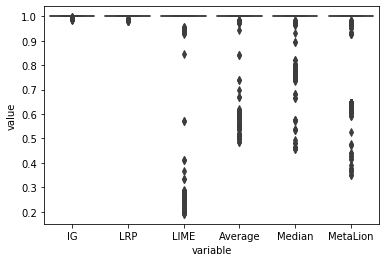

In [60]:
import seaborn as sns
lip_df = pd.DataFrame({'IG':stability['cNN'][0], 'LRP':stability['cNN'][1], 'LIME':stability['cNN'][2], # 'RAND':stability['cNN'][3], 
                        'Average':stability_meta['cNN'][0], 'Median':stability_meta['cNN'][1], 'MetaLion':stability_meta['cNN'][2]})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df))

In [61]:
lip_df_lnn = pd.DataFrame({'IG':stability['lNN'][1], 'LRP':stability['lNN'][2], 'LIME':stability['lNN'][3], 'RAND':stability['lNN'][4]})
lip_df_nn = pd.DataFrame({'IG':stability['NN'][0], 'LRP':stability['NN'][1], 'LIME':stability['NN'][2], 'RAND':stability['NN'][3]})
lip_df_cnn = pd.DataFrame({'IG':stability['cNN'][0], 'LRP':stability['cNN'][1], 'LIME':stability['cNN'][2], 'RAND':stability['cNN'][3]})

## Consistency

In [63]:
consistency = {}
for idf,fi_name in enumerate(['IG', 'LRP', 'LIME', 'RAND']):
    all_importance_tests = []
    for neural_name, neural_type in predict_functions.items():

        path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D4\\'
        with open(path + 'D4_'+neural_name+'.txt') as json_file:
            importances = json.load(json_file)
        importance_test = np.array(importances['test'])
        
        if neural_name == 'lNN':
            all_importance_tests.append(importance_test[:,1:])
        else:
            all_importance_tests.append(importance_test[:])
    all_importance_tests = np.array(all_importance_tests)
    consistency[fi_name] = gm.consistency(all_importance_tests[:,:,idf])
    print(fi_name, np.mean(consistency[fi_name]))

IG 0.9999997968890628
LRP 0.27794576159343476
LIME 0.2554657700983842
RAND 1.0


In [64]:
consistency_meta = {}
for idf, meta_name in enumerate(meta_names):
    all_importance_tests = []
    for neural_name, neural_type in predict_functions.items():
        all_importance_tests.append(np.array(meta_interpretations_test[neural_name]))
    all_importance_tests = np.array(all_importance_tests)
    consistency_meta[meta_name] = gm.consistency(all_importance_tests[:,:,idf])
    print(meta_name, np.mean(consistency_meta[meta_name]))

Average 0.489242985732668
Median 0.4381175966281792
RuleBased 0.34425058932995245


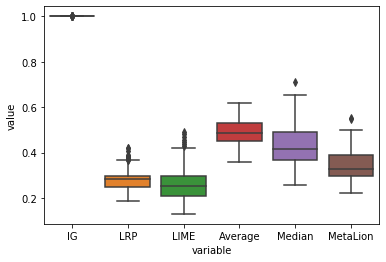

In [65]:
import seaborn as sns
con_df = pd.DataFrame({'IG':consistency['IG'], 'LRP':consistency['LRP'], 'LIME':consistency['LIME'], #'RAND':consistency['RAND'], 
                        'Average':consistency_meta['Average'], 'Median':consistency_meta['Median'], 'MetaLion':consistency_meta['RuleBased']})
sns.boxplot(x="variable", y="value", data=pd.melt(con_df))

In [66]:
import seaborn as sns
con_df_models = pd.DataFrame({'IG':consistency['IG'], 'LRP':consistency['LRP'], 'LIME':consistency['LIME'], 'RAND':consistency['RAND']})

In [51]:
from tqdm import tqdm
from sklearn.compose import ColumnTransformer
pd_x_test = pd.DataFrame(x_test_emb.reshape((len(x_test_emb),250*768)), columns=['S'+str(i) for i in range(250*768)])
ct = ColumnTransformer([('_INXAI_normal_noise_perturber', NormalNoisePerturber(scale=2),pd_x_test.columns)])
auprc = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D4\\'
    with open(path + 'D4_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_test = np.array(importances['test'])
    meta_explain = MetaExplain(None, flat_features)

    new_tests = []
    for instan in range(len(x_test_emb)):
        new_test = []
        for inter in range(len(fi_techniques)):
            new_interpretation = []
            for i in range(250):
                new_interpretation.append([importance_test[instan][inter][i] for j in range(768)])
            new_interpretation = np.array(new_interpretation)
            new_test.append(new_interpretation)
        new_tests.append(new_test)
    new_tests = np.array(new_tests)
    print(importance_test.shape)
    print('Starting evaluation for', neural_name)
    model_auprc = []
    for idf,fi_name in tqdm(enumerate(fi_names)):
        print('watch me!')
        mean_fi = np.array(new_tests[:,idf]).reshape((len(new_tests),250*768)).mean(axis=0)
        model_auprc.append(gm.gradual_perturbation(model=models[neural_name], X=pd_x_test, y=y_test, column_transformer=ct, importances_orig=mean_fi, 
                                        resolution=10,  count_per_step=10, plot=False, task='c', reshape=(250,768)))
    auprc[neural_name] = model_auprc

(605, 5, 250)
Starting evaluation for lNN
watch me!


watch me!


watch me!


watch me!


watch me!


5it [45:50, 550.10s/it]


(605, 4, 250)
Starting evaluation for NN
watch me!


watch me!


watch me!


watch me!


4it [44:50, 672.64s/it]


(605, 4, 250)
Starting evaluation for cNN
watch me!


watch me!


watch me!


watch me!


4it [45:48, 687.11s/it]


In [53]:
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    print(neural_name)
    for idf, auprc_score in enumerate(auprc[neural_name]):
        print(fi_names[idf], np.mean(auprc_score))

lNN
Inherent 0.012330578512396672
IG 0.012396694214876025
LRP 0.011586776859504133
LIME 0.010909090909090913
RAND 0.011851239669421466
NN
IG 0.02406611570247944
LRP 0.02284297520661165
LIME 0.02277685950413233
RAND 0.02276033057851251
cNN
IG 0.2934710743801653
LRP 0.29309090909090907
LIME 0.29183471074380163
RAND 0.29388429752066114


In [55]:
from sklearn.metrics import auc

auprc_df_lnn = pd.DataFrame({'IG':[auc(np.linspace(0, 1, 10),auprc['lNN'][1])], 'LRP':[auc(np.linspace(0, 1, 10),auprc['lNN'][2])], 'LIME':[auc(np.linspace(0, 1, 10),auprc['lNN'][3])], 'RAND':[auc(np.linspace(0, 1, 10),auprc['lNN'][4])]})
auprc_df_nn = pd.DataFrame({'IG':[auc(np.linspace(0, 1, 10),auprc['NN'][0])], 'LRP':[auc(np.linspace(0, 1, 10),auprc['NN'][1])], 'LIME':[auc(np.linspace(0, 1, 10),auprc['NN'][2])], 'RAND':[auc(np.linspace(0, 1, 10),auprc['NN'][3])]})
auprc_df_cnn = pd.DataFrame({'IG':[auc(np.linspace(0, 1, 10),auprc['cNN'][0])], 'LRP':[auc(np.linspace(0, 1, 10),auprc['cNN'][1])], 'LIME':[auc(np.linspace(0, 1, 10),auprc['cNN'][2])], 'RAND':[auc(np.linspace(0, 1, 10),auprc['cNN'][3])]})

In [67]:
cons_alpha = 0.2
lip_alpha=20
auc_alpha=0.1

In [68]:
weights = cons_alpha*con_df_models.iloc[33]+lip_alpha*lip_df_lnn.iloc[33]+auc_alpha/auprc_df_lnn
weights

,IG,LRP,LIME,RAND
0,28.815506,29.227563,29.812694,29.11162


Let's evaluate inXAI now!

In [71]:

inxai_stabilities = []
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]

    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D4\\'
    with open(path + 'D4_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_test = np.array(importances['test'])

    inxai = []
    for idf, instance in enumerate(x_test_emb):
        if neural_name == 'lNN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_lnn.iloc[idf]+auc_alpha/auprc_df_lnn
            met = weights.dot(np.array([np.array(i) for i in importance_test[idf][1:]]))/weights.sum().sum()
        elif neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        inxai.append(met.values[0])
    print(np.array(inxai).shape)
    print('Starting evaluation for', neural_name)
    inxai_stability = gm.stability(pd.DataFrame(x_test_emb.reshape((len(x_test_emb),250*768))), 
                                   np.array(inxai) ,epsilon=50)
    print('inXAI', np.mean(inxai_stability))
    inxai_stabilities.append(np.mean(inxai_stability))

(605, 250)
Starting evaluation for lNN
inXAI 0.9457527998236899
(605, 250)
Starting evaluation for NN
inXAI 0.9542242102377544
(605, 250)
Starting evaluation for cNN
inXAI 0.9695621276049207


In [73]:
all_importance_tests = []
for neural_name, neural_type in predict_functions.items():
    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D4\\'
    with open(path + 'D4_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_test = np.array(importances['test'])
        
    testss = []
    for idf, instance in enumerate(x_test_emb):
        if neural_name == 'lNN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_lnn.iloc[idf]+auc_alpha/auprc_df_lnn
            met = weights.dot([np.array(i) for i in importance_test[idf][1:]])/weights.sum().sum()
        elif neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        testss.append(met.values[0])
    all_importance_tests.append(testss)
all_importance_tests = np.array(all_importance_tests)
inxai_consistency = gm.consistency(all_importance_tests)
print('inXAI', np.mean(inxai_consistency))

inXAI 0.49790522453372865


## Truthfulness and complexity evaluation

In [ ]:
import time
predict_functions = {'lNN': predict_lNN, 'NN': predict_NN, 'cNN': predict_cNN}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']

    meta_names = ['Average', 'Median', 'RuleBased']
    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D4\\'
    with open(path + 'D4_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_test = np.array(importances['test'])
    meta_explain = MetaExplain(None, flat_features)

    ts = time.time()
    print('Starting evaluation for', neural_name)
    step = 0
    for noise in ['normal']: #Noise doesn't affect the evaluation on textual data
        for delta in [0, 0.0001, 0.001, 0.01, 0.1]:
            print('Step', step+1, 'out of 4')
            step = step + 1
            my_altruist = Altruist(neural_type, x_train_emb, fi_techniques, flat_features,
                                   level=noise, delta=delta, data_type='Embeddings')
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(x_test_emb)):

                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(
                    x_test_emb[j], importance_test[j])
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)

                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                temp_meta = []
                temp_meta.append(meta_explain.meta_avg(b))
                temp_meta.append(meta_explain.meta_median(b))
                temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
                for i in range(len(temp_meta)):
                    cnzw = 0
                    cnzwt = 0
                    for k in temp_meta[i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i+len(importance_test[j])].append(cnzw)
                    nzw_scores_delta[i+len(importance_test[j])].append(cnzwt)
                my_altruist.fis = len(meta_names)
                a = my_altruist.find_untruthful(x_test_emb[j], temp_meta)
                for i in range(len(a[0])):
                    meta_scores[i].append(len(a[0][i]))
            count = 0
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
                count = count + 1
            count = 0
            for meta_score in meta_scores:
                count = count + 1
                row.append(np.array(meta_score).mean())
            with open('D4_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names+meta_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D4_NZW_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
    print('Time', time.time() - ts)
    ts = time.time()

and for inXAI

In [74]:
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    elif neural_name == 'NN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    else:
        fi_techniques = [fi_random]
        fi_names = ['inXAI']


    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D4\\'
    with open(path + 'D4_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_test = np.array(importances['test'])
    meta_explain = MetaExplain(None, flat_features)
    
    testss = []
    for idf, instance in enumerate(x_test_emb):
        if neural_name == 'lNN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_lnn.iloc[idf]+auc_alpha/auprc_df_lnn
            met = weights.dot([np.array(i) for i in importance_test[idf][1:]])/weights.sum().sum()
        elif neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        testss.append([met.values[0]])
    importance_test = np.array(testss)

    print('Starting evaluation for', neural_name)
    step = 0
    for noise in ['normal']:
        for delta in [0 , 0.0001, 0.001, 0.01]:
            print('Step', step+1, 'out of 4')
            step = step + 1
            my_altruist = Altruist(neural_type, x_train_emb, fi_techniques, flat_features,
                                   level=noise, delta=delta, data_type='Embeddings')
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(x_test_emb)):
                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(
                    x_test_emb[j], importance_test[j])
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                
            count = 0
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            with open('D4_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D4_NZW_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)

Starting evaluation for lNN
Step 1 out of 4
Step 2 out of 4
Step 3 out of 4
Step 4 out of 4
Starting evaluation for NN
Step 1 out of 4
Step 2 out of 4
Step 3 out of 4
Step 4 out of 4
Starting evaluation for cNN
Step 1 out of 4
Step 2 out of 4
Step 3 out of 4
Step 4 out of 4


Ablation Study

In [ ]:
import time
predict_functions = {'NN': predict_NN, 'cNN': predict_cNN}
for neural_name, neural_type in predict_functions.items():
    fi_techniques = [fi_LRP_NN, fi_lime, fi_random]
    fi_names = ['LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']
    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D4\\'
    with open(path + 'D4_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_test = np.array(importances['test'])
    importance_test = np.delete(importance_test, 2, axis=1)
    meta_explain = MetaExplain(None, flat_features)

    ts = time.time()
    print('Starting evaluation for', neural_name)
    step = 0
    for noise in ['normal']:
        for delta in [0.0001]:
            step = step + 1
            my_altruist = Altruist(neural_type, x_train_emb, fi_techniques, flat_features,
                                   level=noise, delta=delta, data_type='Embeddings')
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(x_test_emb)):

                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(
                    x_test_emb[j], importance_test[j])
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)

                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                temp_meta = []
                temp_meta.append(meta_explain.meta_avg(b))
                temp_meta.append(meta_explain.meta_median(b))
                temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
                for i in range(len(temp_meta)):
                    cnzw = 0
                    cnzwt = 0
                    for k in temp_meta[i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i+len(importance_test[j])].append(cnzw)
                    nzw_scores_delta[i+len(importance_test[j])].append(cnzwt)
                my_altruist.fis = len(meta_names)
                a = my_altruist.find_untruthful(x_test_emb[j], temp_meta)
                for i in range(len(a[0])):
                    meta_scores[i].append(len(a[0][i]))
            count = 0
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
                count = count + 1
            count = 0
            for meta_score in meta_scores:
                count = count + 1
                row.append(np.array(meta_score).mean())
            with open('D4_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names+meta_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D4_NZW_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
    print('Time', time.time() - ts)
    ts = time.time()

and ablation for inXAI

In [80]:
predict_functions = {'NN': predict_NN, 'cNN': predict_cNN}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    elif neural_name == 'NN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    else:
        fi_techniques = [fi_random]
        fi_names = ['inXAI']


    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D4\\'
    with open(path + 'D4_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_test = np.array(importances['test'])
    meta_explain = MetaExplain(None, flat_features)
    fi = 3
    importance_test = np.delete(importance_test, fi, axis=1)
    testss = []
    for idf, instance in enumerate(x_test_emb):
        if neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            weights = weights.drop(weights.columns[[fi]],axis = 1)
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            weights = weights.drop(weights.columns[[fi]],axis = 1)
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        testss.append([met.values[0]])
    importance_test = np.array(testss)

    print('Starting evaluation for', neural_name)
    step = 0
    for noise in ['normal']:
        for delta in [0.0001]:
            print('Step', step+1, 'out of 4')
            step = step + 1
            my_altruist = Altruist(neural_type, x_train_emb, fi_techniques, flat_features,
                                   level=noise, delta=delta, data_type='Embeddings')
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(x_test_emb)):
                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(
                    x_test_emb[j], importance_test[j])
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                
            count = 0
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            with open('D4_Ablation_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D4_Ablation_NZW_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)

Starting evaluation for NN
Step 1 out of 4
Starting evaluation for cNN
Step 1 out of 4


## Qualitative Example
We select the 77th instance

In [81]:
import time
predict_NN
neural_name = 'cNN'
fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
fi_names = ['IG', 'LRP', 'LIME', 'RAND']

meta_names = ['Average', 'Median', 'RuleBased']
path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D4\\'
with open(path + 'D4_'+neural_name+'.txt') as json_file:
    importances = json.load(json_file)
importance_test = np.array(importances['test'])
meta_explain = MetaExplain(None, flat_features)

noise = 'normal'
delta = 0.0001
my_altruist = Altruist(predict_cNN, x_train_emb, fi_techniques, flat_features,
                       level=noise, delta=delta, data_type='Embeddings')

j = 77
scores = [len(x_test[j].split(' '))]
my_altruist.fis = len(fi_techniques)
a = my_altruist.find_untruthful(x_test_emb[j], importance_test[j])
b = np.array(a[-1])
for i in range(len(a[0])):
    scores.append(len(a[0][i]))
temp_meta = []
temp_meta.append(meta_explain.meta_avg(b))
temp_meta.append(meta_explain.meta_median(b))
temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
my_altruist.fis = len(meta_names)
a = my_altruist.find_untruthful(x_test_emb[j], temp_meta)
for i in range(len(a[0])):
    scores.append(len(a[0][i]))


In [82]:
weights = cons_alpha*con_df_models.iloc[j]+lip_alpha*lip_df_cnn.iloc[j]+auc_alpha/auprc_df_cnn
met = weights.dot([np.array(i) for i in importance_test[j]])/weights.sum().sum()
met.values[0]

array([-0.40404265,  0.41804646,  0.24177183,  0.40153328, -0.1241138 ,
       -0.03524444,  0.01681027, -0.04319938,  0.24069312,  0.09844386,
       -0.10728819,  0.04949483,  0.00862006,  0.03752718,  0.05095734,
        0.17166968, -0.08856611, -0.00459182,  0.22917045,  0.04216089,
       -0.05560519, -0.06076582,  0.06314021,  0.02780989,  0.04587599,
        0.14703204,  0.15186487,  0.14103693,  0.11782901,  0.1695852 ,
        0.04570526,  0.21490805,  0.07067198,  0.18950673,  0.15783293,
       -0.03407266,  0.03376973,  0.11336484, -0.0540225 ,  0.05806887,
        0.04497924,  0.05254743,  0.01854257,  0.02859458, -0.06107175,
        0.08523263, -0.03133804, -0.17496039,  0.02803691, -0.01630961,
        0.1694368 ,  0.00460143,  0.07173229,  0.00985018,  0.036757  ,
        0.02455458,  0.0246514 ,  0.04459515,  0.02569267, -0.07102462,
       -0.02549549,  0.00711157,  0.00058253, -0.02550458,  0.00505643,
       -0.02306526,  0.00355069,  0.01366781, -0.00590525,  0.03

In [83]:
size = len(x_test[j].split(' '))
size

72

In [84]:
y_test[j], predict_cNN(np.array([x_test_emb[j]]))[0]

(1, 0.92689556)

In [85]:
# This is a utility method visualizing the relevance scores of each word to the network's prediction.
# one might skip understanding the function, and see its output first.
# This code is from the Innvestigate library: https://innvestigate.readthedocs.io

def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height), dpi=150)

    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5

    loc_y = -0.2
    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        text = ax.text(0.0, loc_y, token,
                       bbox={'facecolor': color, 'pad': 3.7, 'linewidth': 0,
                           'boxstyle': 'round,pad=0.37' }, transform=t)
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y - 2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')
    if verbose == 0:
        ax.axis('off')

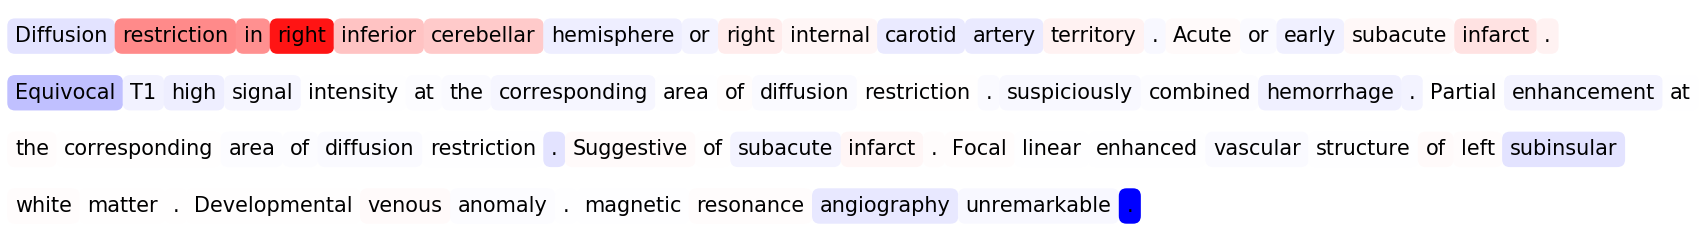

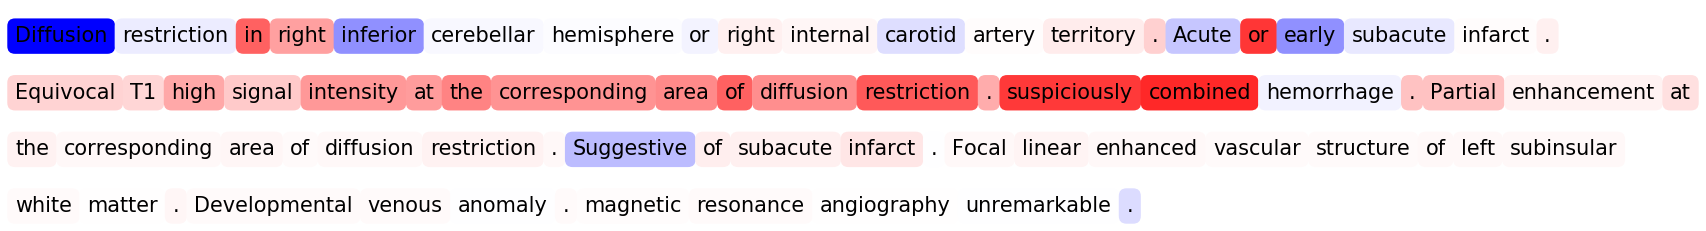

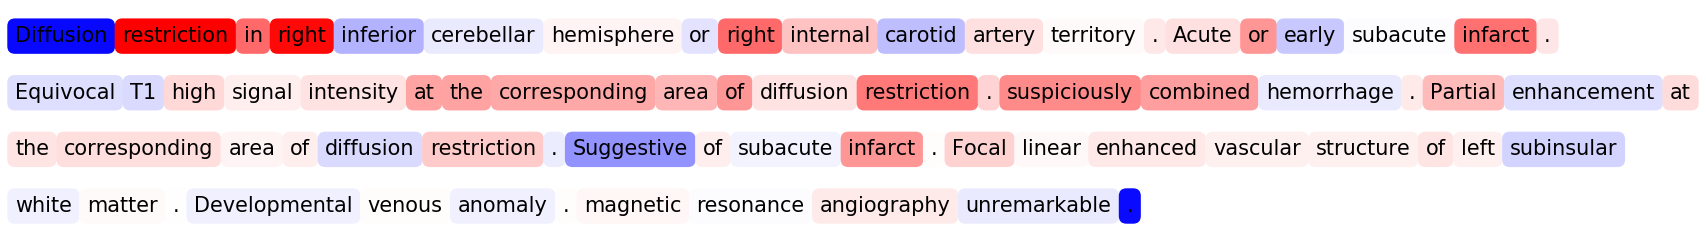

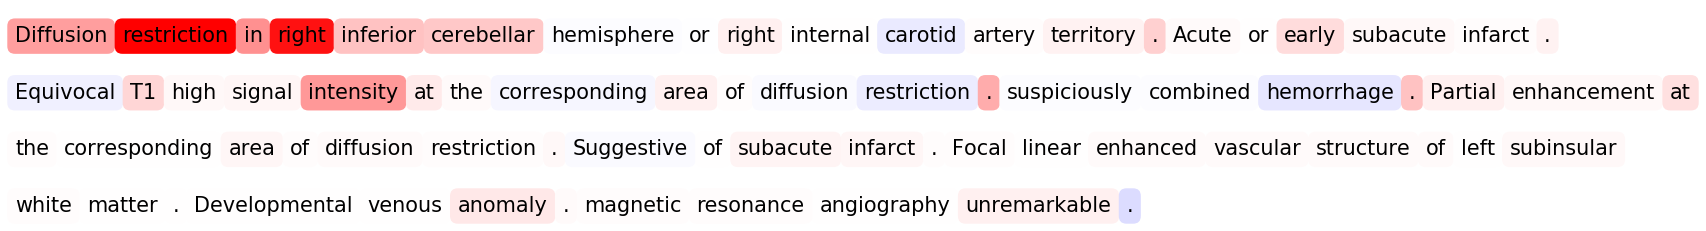

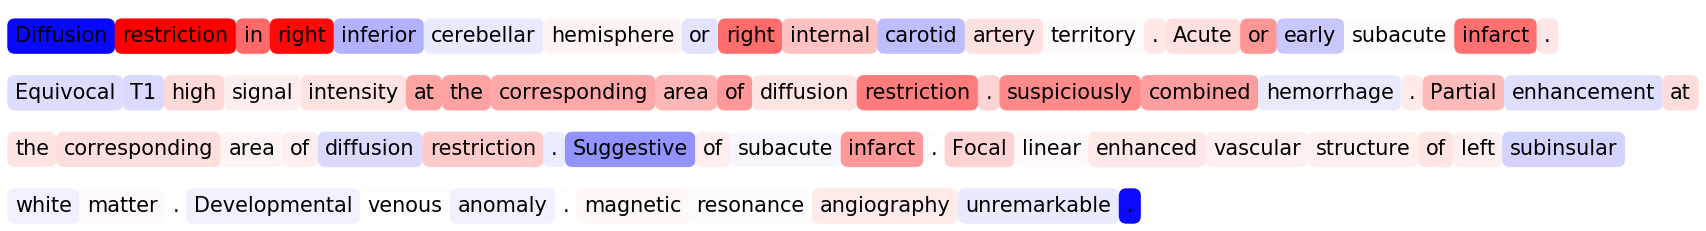

In [88]:
import matplotlib.pyplot as plt
from matplotlib import cm, transforms

plot_text_heatmap(
    x_test[j].split(' '),
    importance_test[j][0][:size]) #IG

plot_text_heatmap(
    x_test[j].split(' '),
    importance_test[j][1][:size]) #LRP

plot_text_heatmap(
    x_test[j].split(' '),
    temp_meta[0][:size]) #Mean

plot_text_heatmap(
    x_test[j].split(' '),
    temp_meta[2][:size]) #OurMeta

plot_text_heatmap(
    x_test[j].split(' '),
   met.values[0]) #inXAI